In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pandas as pd, numpy as np
#from shapely.geometry import Polygon
#from shapely.geometry import Point
import geopandas
import matplotlib.cm as cm

import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

from sklearn.cluster import DBSCAN

#### There are two main groups of activities you can do with Clustering

If you are interested in using Kmeans to describe your (unlabeled) data, you can use Kmeans to split your data into k clusters and then analyze the clusters. This is what we are going to do in this notebook.

You can also use a similar process called K-nearest neighbors (KNN) for classification tasks. In KNN, clusters are formed with labeled data and then unlabeled data is categorized into the clusters. Trying out the KNN algorithm for a classification task would be a create project idea!

The good news is that although Kmeans is a machine learning algorithm, it is reletively simple to implement. You don't have to be familiar with the math behind KMeans, but you should understand what the algorithm is doing conceptually (see powerpoint).



### The Data
For the purposes of this exercise, we are going to be using a dataset of 10,550 transit stops in California, along with 23 charactaristics of the transit stops and their surrounding neighborhoods. 

It was created by two students who graduated from the MCP program (Simon Hochberg '19, Jared Nolan '19). Jared used this data for his final project in a graduate level transportation data science class here in CED. Check it out on bcourses.


In [104]:
#when this notebook is in datahub we will change the file path 
stops = pd.read_csv("/Users/ameliabaum/Desktop/Amelia/CP 101/stop_stats.csv")
stops.head()

,Unnamed: 0,key,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,...,pct_smallmf,pct_bigmf,pct_medmf,pct_vacant,pct_since2000,pct_before1950,pct_bach_degree,pct_hh_kids,pct_unemp_civ,density
0,0,AC Transit1000340,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
1,1,AC Transit1000350,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
2,2,AC Transit1000370,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
3,3,AC Transit1000380,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
4,4,AC Transit1000410,2993.0,0.597067,1075287.0,0.782577,0.218844,0.08854,0.210157,0.446709,...,0.145415,0.606734,0.171920,0.021490,0.341691,0.270774,0.350773,0.116398,0.096386,11645.914093


In [105]:
# stops.columns


The Kmeans algorithm only works with numeric data (floats and ints, in Python). Remove the column with the stop label so that the data being put into the algorithm only consists of the numeric stop charactaristics.

You might notice that a lot of the rows have the same values for the demographic variables. That is because the demographic variables are aggregated at the neighborhood level- and there are many transit stops in the same neighborhood.

In [106]:
X = stops.iloc[:, 2:]
X.head()

,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,pct_below200pov,hispanic_pov,...,pct_smallmf,pct_bigmf,pct_medmf,pct_vacant,pct_since2000,pct_before1950,pct_bach_degree,pct_hh_kids,pct_unemp_civ,density
0,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,0.571678,0.308511,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
1,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,0.571678,0.308511,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
2,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,0.571678,0.308511,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
3,4888.0,0.537709,1065622.0,0.764959,0.132160,0.04644,0.090221,0.684534,0.571678,0.308511,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
4,2993.0,0.597067,1075287.0,0.782577,0.218844,0.08854,0.210157,0.446709,0.546131,0.113636,...,0.145415,0.606734,0.171920,0.021490,0.341691,0.270774,0.350773,0.116398,0.096386,11645.914093


This code below creates a KMeans object with k clusters (n_clusters). Play around with this variable to see what happens to the clusters visually later in the notebook. The data X is then fitted to the Kmeans object, which generates a set of 10,550 labels-one label for each stop!

In [107]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Make a column called "cluster" in the stops dataset to see the labeled data. There are k unique entries in the y_kmeans array, one for each cluster that you specified above. It makes a bit more sense to think about the clusters as beginning with cluster 1 instead of cluster 0, so let's shift the array by 1.

In [108]:
np.unique(y_kmeans+1)

array([1, 2, 3, 4], dtype=int32)

In [109]:
stops["cluster"] = y_kmeans+1
stops

,Unnamed: 0,key,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,...,pct_bigmf,pct_medmf,pct_vacant,pct_since2000,pct_before1950,pct_bach_degree,pct_hh_kids,pct_unemp_civ,density,cluster
0,0,AC Transit1000340,4888.0,0.537709,1.065622e+06,0.764959,0.132160,0.046440,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2
1,1,AC Transit1000350,4888.0,0.537709,1.065622e+06,0.764959,0.132160,0.046440,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2
2,2,AC Transit1000370,4888.0,0.537709,1.065622e+06,0.764959,0.132160,0.046440,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2
3,3,AC Transit1000380,4888.0,0.537709,1.065622e+06,0.764959,0.132160,0.046440,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2
4,4,AC Transit1000410,2993.0,0.597067,1.075287e+06,0.782577,0.218844,0.088540,0.210157,0.446709,...,0.606734,0.171920,0.021490,0.341691,0.270774,0.350773,0.116398,0.096386,11645.914093,2
5,5,AC Transit1000430,4888.0,0.537709,1.065622e+06,0.764959,0.132160,0.046440,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2
6,6,AC Transit1000460,4159.0,0.987430,1.053421e+06,0.774791,0.204136,0.075980,0.096417,0.544843,...,0.713853,0.056710,0.065801,0.374026,0.215152,0.430692,0.165894,0.139866,11617.318102,2
7,7,AC Transit1000490,3167.0,0.440642,1.054378e+06,0.782744,0.066309,0.017682,0.043890,0.823177,...,0.833523,0.099432,0.084659,0.128409,0.330682,0.228539,0.134699,0.074700,23286.763439,2
8,8,AC Transit1000520,4159.0,0.987430,1.053421e+06,0.774791,0.204136,0.075980,0.096417,0.544843,...,0.713853,0.056710,0.065801,0.374026,0.215152,0.430692,0.165894,0.139866,11617.318102,2
9,9,AC Transit1000680,6409.0,0.735335,1.006158e+06,0.821825,0.077703,0.212670,0.191762,0.442971,...,0.138765,0.215309,0.072963,0.043420,0.442256,0.175650,0.393530,0.168636,21506.711915,2


**How do we know how many clusters best describe the data?** If we use too many clusters, we will have too few datapoints in each cluster and the clusters will not be meaningful. If we have not enough, the data in each of the clusters will be too disparate. There are at least two ways to determine the optimal number of clusters to describe the data. 

1. An elbow plot shows the number of clusters vs. the distortion of the dataset. The **distortion** is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used. A higher distortion indicates greater distances *between* the clusters, meaning that they are more distinct (that is good!). 

This plot shows the average distortion for up to 10 different clusters. What do you notice about the shape of the graph?

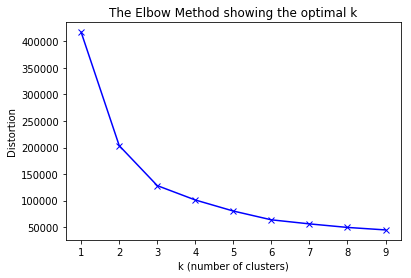

In [110]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(Xx)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
# plt.savefig('Graphics/elbow.png',dpi=600)
plt.show()

Rather than being smooth, the plot is made from distinct segments, and has "elbow shaped" corners at 2 and 3 clusters. These are the values where there is a significant reduction in distortion as a result of an increase in number of clusters. This is an indication that we should stop dividing the data into further clusters. From this elbow plot, it seems that the optimal number of clusters for this dataset is around 3. 

2. We can also use a metric called a silhouette score, and visualize clustered data projected onto two features at a time. The silhouette score measures the degree to which a given datapoint is correctly classified to a given cluster. The Silhouette score ranges from [-1,1]. Scores close to -1 indicate that many points are in the wrong cluster, suggesting that there are too few or too many clusters in the model. Scores close to +1 indicate that most points are closely matched to their own clusters, and poorly matched to other clusters. This is what we want, so higher silhouette scores are better.

In [111]:
y=X
# y.iloc[:, 0] 

For n_clusters = 2 The average silhouette_score is : 0.6821591695407774
For n_clusters = 3 The average silhouette_score is : 0.65359563297554
For n_clusters = 4 The average silhouette_score is : 0.613252965896096
For n_clusters = 5 The average silhouette_score is : 0.6080829176447847
For n_clusters = 6 The average silhouette_score is : 0.6116529076508558


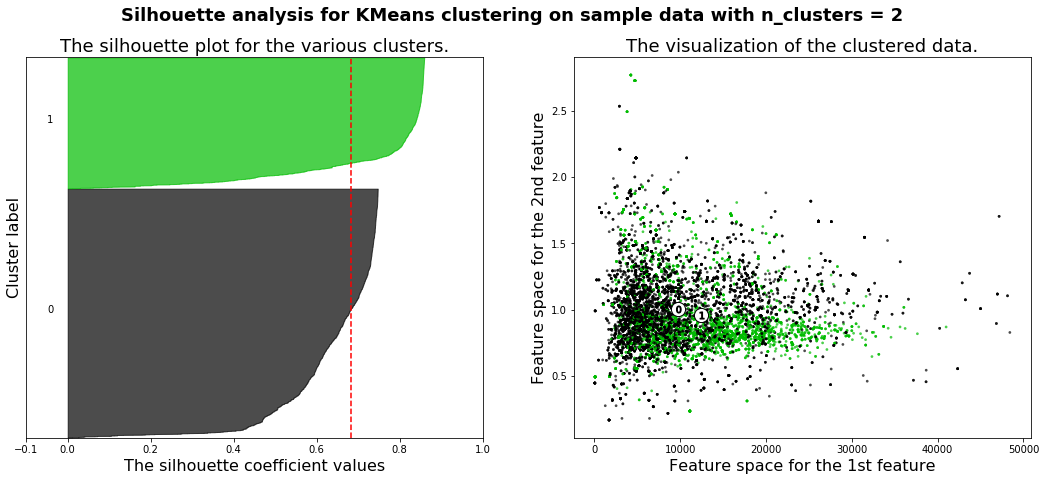

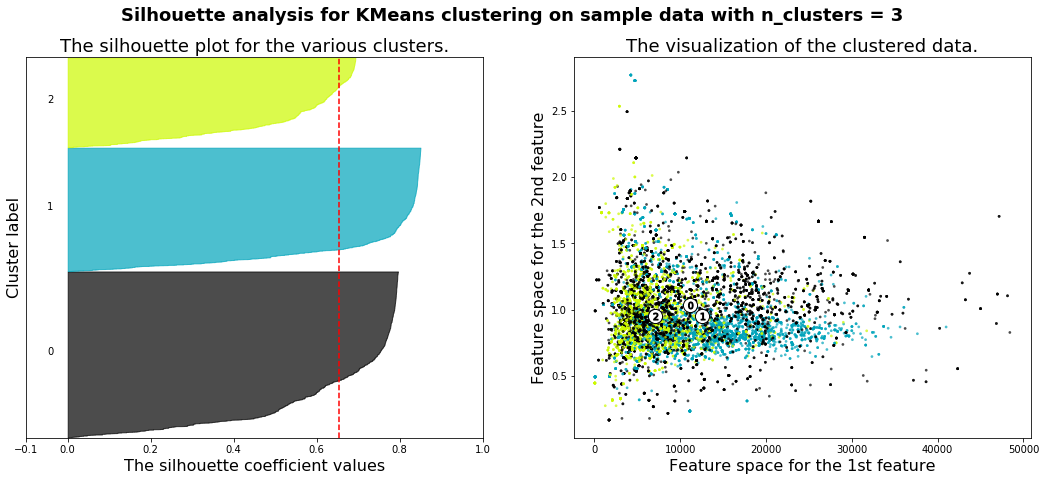

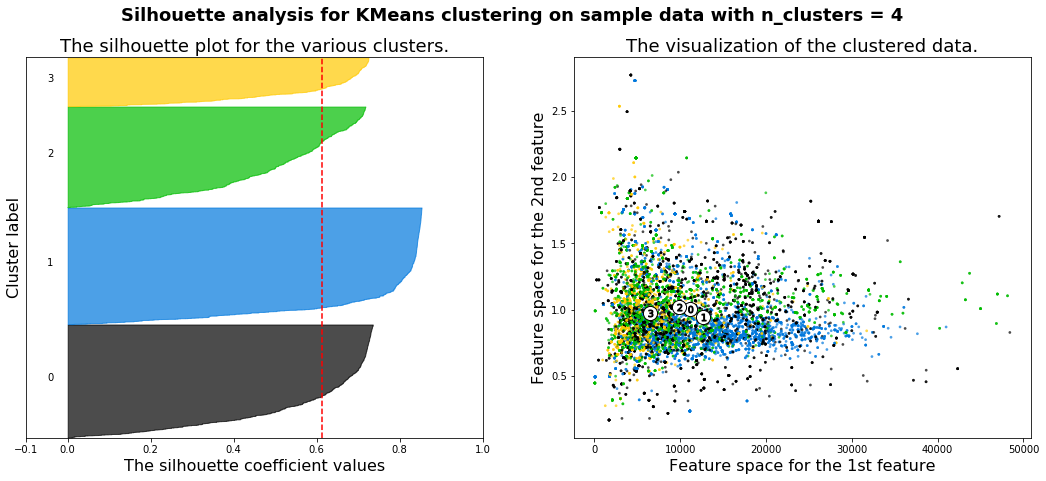

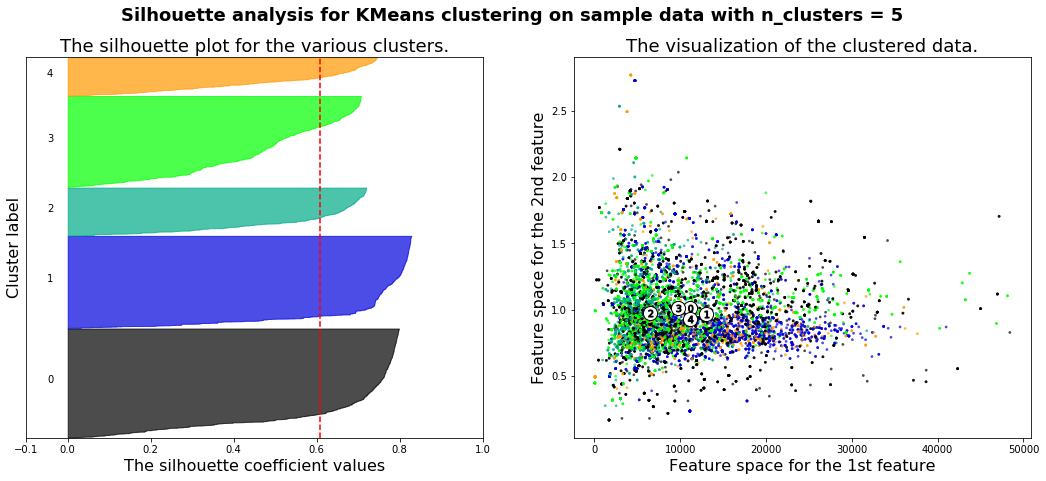

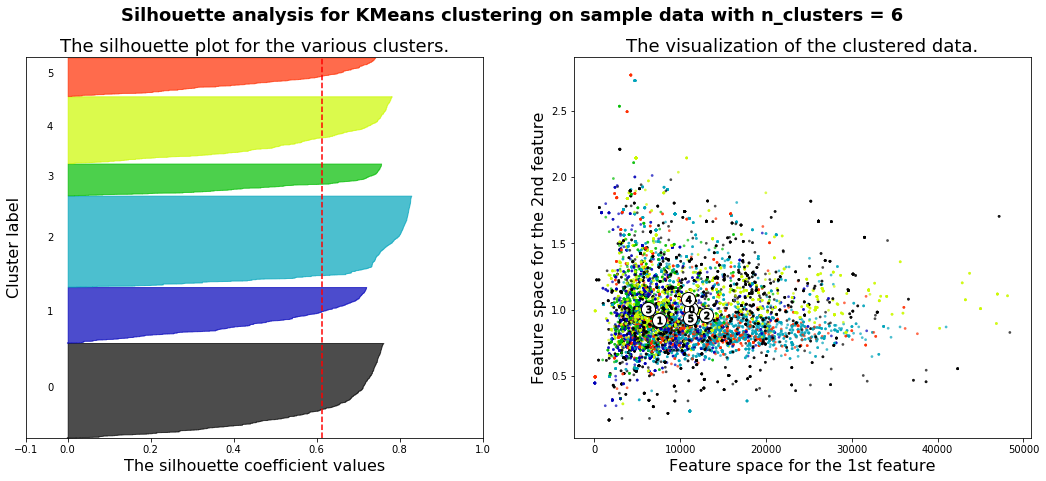

In [112]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(y) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(y, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(y, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=18)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=16)
    ax1.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(y.iloc[:, 0], y.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.", fontsize=18)
    ax2.set_xlabel("Feature space for the 1st feature", fontsize=16)
    ax2.set_ylabel("Feature space for the 2nd feature", fontsize=16)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=18, fontweight='bold')

plt.show()

All of these clusters look pretty good! What happens if you keep increasing the number of clusters? A silhouette score above 0.5 is considered a good indication that the data is separable (classifiable into clusters).

#### Unsuccessful CLustering

A silhouette score that is a lot less than 0.5 is an indication that the number of clusters is wrong, or that the data is not naturally clusterable. If you get a silhouette score of less than 0.5 in your own project, consider transforming your data or using a different approach. Here is an example of what your results might look like if your data is not easily clusterable. 

Let's say you only have a subset of the stops dataset, only the 'pct_rent', 'pct_white', 'pct_hispanic', 'pct_black', 'pct_asian', 'pct_below200pov', 'pct_since2000', 'pct_before1950', 'pct_bach_degree' columns

In [113]:
y = stops[['pct_rent',
       'pct_white', 'pct_hispanic', 'pct_black', 'pct_asian',
       'pct_below200pov', 'pct_since2000', 'pct_before1950', 'pct_bach_degree']]

For n_clusters = 2 The average silhouette_score is : 0.3406509532224654
For n_clusters = 3 The average silhouette_score is : 0.26603434400602977
For n_clusters = 4 The average silhouette_score is : 0.2541715530953073
For n_clusters = 5 The average silhouette_score is : 0.2469306222493471
For n_clusters = 6 The average silhouette_score is : 0.2304757538556709


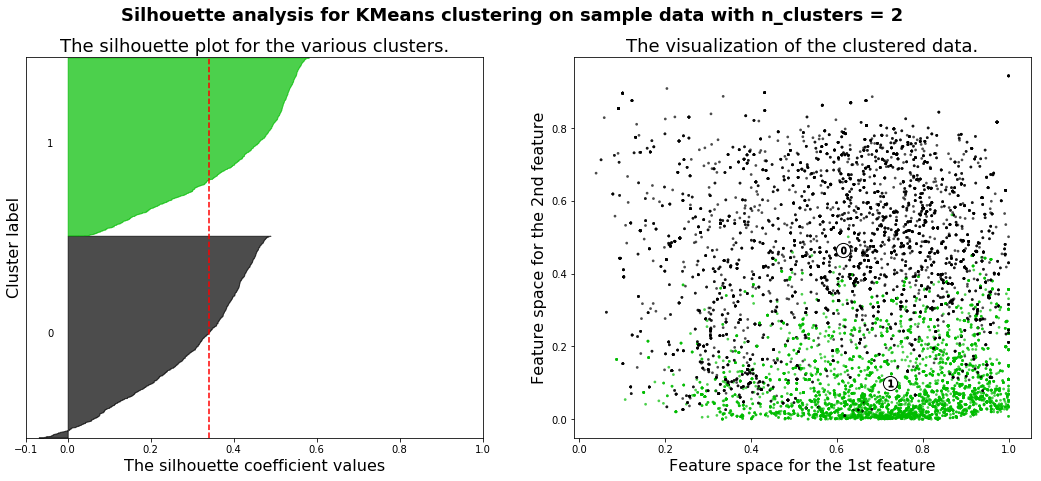

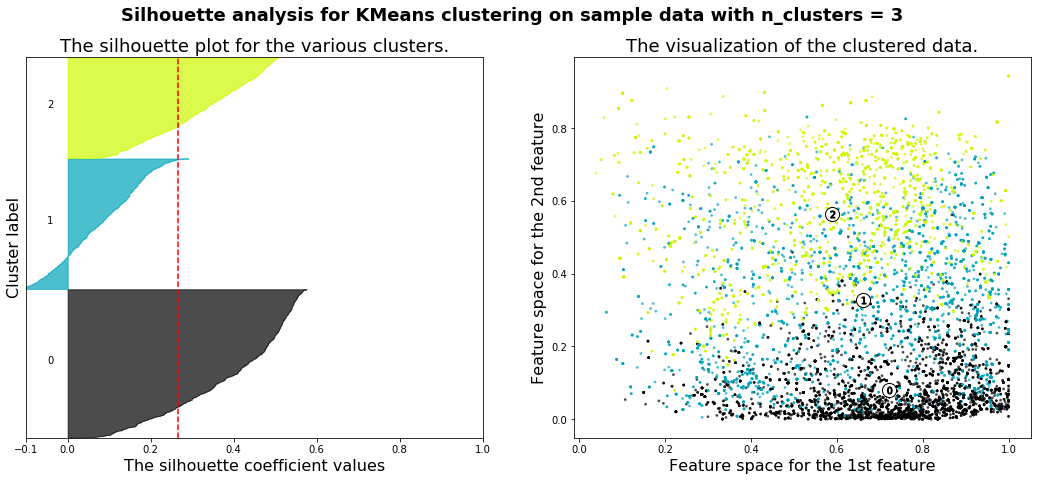

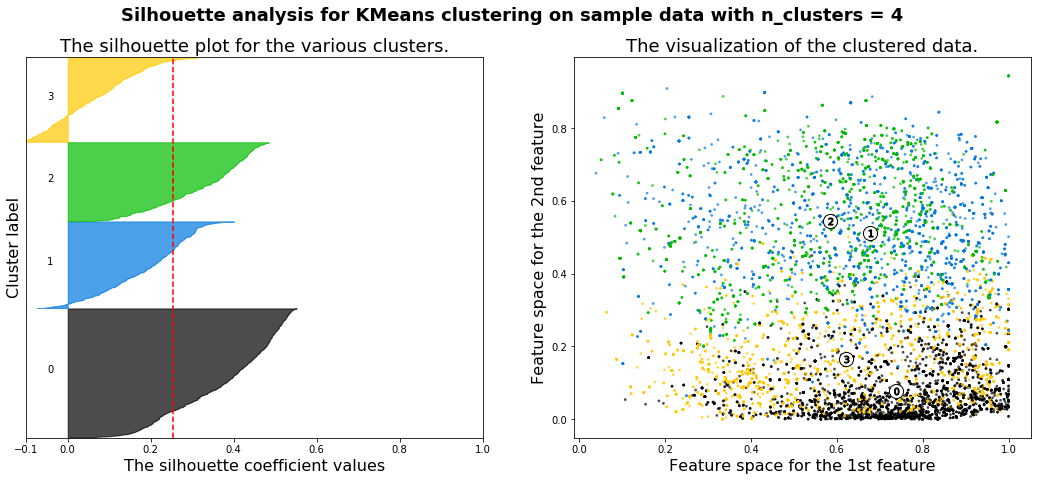

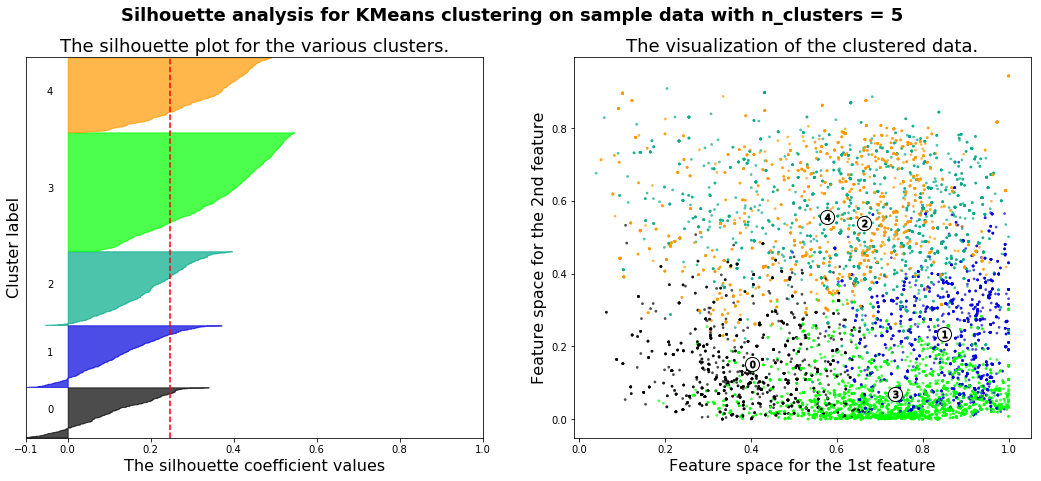

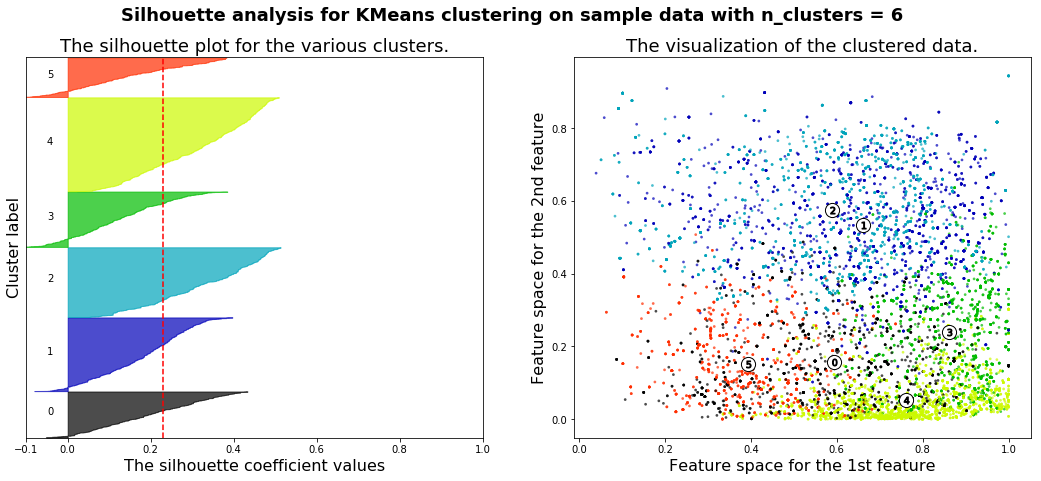

In [114]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(y) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(y, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(y, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=18)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=16)
    ax1.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(y.iloc[:, 0], y.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.", fontsize=18)
    ax2.set_xlabel("Feature space for the 1st feature", fontsize=16)
    ax2.set_ylabel("Feature space for the 2nd feature", fontsize=16)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=18, fontweight='bold')

plt.show()

### Analyzing the Clusters
Let's look at some summary statistics of the 3 clusters and see how they are similar to and different from each other

[TO DO]

In [117]:
cluster1 = stops[stops["cluster"] == 1]
cluster2 = stops[stops["cluster"] == 2]
cluster3 = stops[stops["cluster"] == 3]


### Discussion Questions

1. How do each of the clusters differ from each other and how are they the same? Do these differences help you understand the data better for a study or research project? Why or why not?

2. How much and what kind of information was lost when we clustered the transit stops?

3. What are some other applications of clustering related to the urban domain?